# Deep Learning based Pipeline with Multichannel Inputs for Multi-class Patent Classification

This notebook describes a deep learning pipeline for automatic patent classification with multichannel inputs.  A neural network model is trained with multichannel inputs namely embeddings of different segments of patent texts, and sparse linear
input of different metadata. <br> <br>

<br>
In this notebook the classification task is a multi-class classification. The basic outline is:  <br>  <br>

- load the patent dataset  <br>
- apply preprocessing tasks  <br>
- apply Tokenization process  <br>
- Load a pretrained word embeddings model  <br>
- prepare the embedding matrix for patent texts   <br>
- concatenated deep layers <br>
- train a deep neural network on the data  <br>
- Fit the model and show the results  <br>


#  Loading patent dataset
We established the training, and test datasets that are related to the information technology domain as well as life science domain.
The total number of extracted records in the datasets is 1,915,308  patents filed between 1978 and 2016. Each patent document contains a  patent number, issued date, patent type, and list of citations, classification codes, a list of inventors, a list of assignees, title, abstract, technical field, background,  summary of invention, and independent claim. <br>
The data det is availabe on request.
   

In [1]:
import pandas as pd

df1 = pd.read_csv("../datasets/allITPatTextWith_Metadata_simple_preprocessed_last.csv",  encoding = "ISO-8859-1", error_bad_lines=False)
df1.columns =['ID','TI','AB','TECHF','BACKG','SUMM','CLMS','ICM','AY','IPC','REF','PA','INV']

df1.dropna(subset=['ICM'], inplace=True)


df1.fillna(value='', inplace=True)
print(df1.count())


df2 = pd.read_csv("../datasets/allLSPatTextWith_Metadata_preprocessed.csv",  encoding = "utf-8", error_bad_lines=False)
df2.columns =['ID','TI','AB','TECHF','BACKG','SUMM','CLMS','ICM','AY','IPC','REF','PA','INV']

df2.dropna(subset=['ICM'], inplace=True)

 

df2.fillna(value='', inplace=True)
print(df2.count())

df = pd.concat([df1, df2], ignore_index=True)
print(df.count())
df.head()

ID       429711
TI       429711
AB       429711
TECHF    429711
BACKG    429711
SUMM     429711
CLMS     429711
ICM      429711
AY       429711
IPC      429711
REF      429711
PA       429711
INV      429711
dtype: int64
ID       1485597
TI       1485597
AB       1485597
TECHF    1485597
BACKG    1485597
SUMM     1485597
CLMS     1485597
ICM      1485597
AY       1485597
IPC      1485597
REF      1485597
PA       1485597
INV      1485597
dtype: int64
ID       1915308
TI       1915308
AB       1915308
TECHF    1915308
BACKG    1915308
SUMM     1915308
CLMS     1915308
ICM      1915308
AY       1915308
IPC      1915308
REF      1915308
PA       1915308
INV      1915308
dtype: int64


,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,"[G06K0019-06, G06K0007-10]",,Video_System_Italia_S_r_l,Tassello_Stefano
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,"[G11B0007-135, G11B0007-125]",,Konica_Minolta_Opto_Inc,Arai_Norikazu Kojima_Toshiyuki Kiriki_Toshihik...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",NEC_Corporation,Maeda_Koji
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,INTERNATIONAL_BUSINESS_MACHINES_CORPORATION CO...,COLYER_ADRIAN_MARK
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,,SAGER_DAVID_J FLETCHER_THOMAS_D HINTON_GLENN_J...


Text(0.5, 0, 'YEAR')

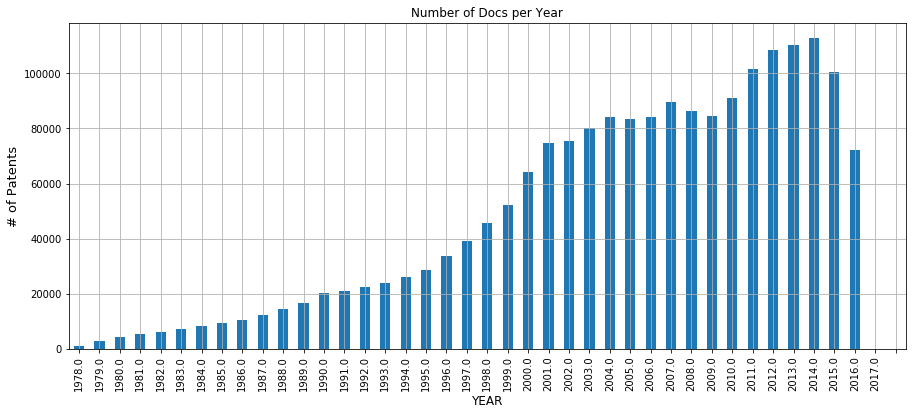

In [3]:
import matplotlib.pyplot as plt

df_AY = df.groupby(['AY'])
df_AY = df_AY.size().reset_index(name='Docs')


df_AY.plot(x='AY', y='Docs', kind='bar', legend=False, grid=True, figsize=(15, 6))
plt.title("Number of Docs per Year")
plt.ylabel('# of Patents', fontsize=13)
plt.xlabel('YEAR', fontsize=12)

# Applying preprocessing tasks on metadat of patent
Converting the metatadata such as inventors and assignees of each patent into a python list, then apply preprocessing task on each element in the list in order to remove undesired tokens.


In [3]:
%%time
#preprocess of list fields
#convert all IPCs in df into one list
def toList(s):
    """
    this method is to convert the list of IPCs in each row from a string to a python List
    """
    s  = s.translate ({ord(c): " " for c in "[]"})
    ss= []
    for cls in s.strip().split(','):
        ss.append(cls.strip())
    return ss

#apply toList method on all rows in the DF
df['PA'] = df['PA'].map(lambda pa :   toList(pa))
df['INV'] = df['INV'].map(lambda inv :   toList(inv))

df.head()  

CPU times: user 13.7 s, sys: 413 ms, total: 14.1 s
Wall time: 14 s


In [4]:
%%time

def metadataPreprocessing(input):
    newInput=' '
    for item in input:
        item = item.translate ({ord(c): " " for c in "!@#$%^&*()'[]{};:,./<>?\|`~°=\"+"})
        itms=' '
        for itm in item.split():
            itms= itms +' '+itm.strip()
        newInput = newInput + ' '+ itms.strip().replace(' ','_')
    return newInput.strip()

df['PA'] = df['PA'].map(lambda pa :   metadataPreprocessing(pa))
df['INV'] = df['INV'].map(lambda inv :   metadataPreprocessing(inv))

df.head()

CPU times: user 29.8 s, sys: 349 ms, total: 30.2 s
Wall time: 30.2 s


#  Applying preprocessing tasks on texts of patent
A simple preprocessing tasks such as tokenization, stopword removal, lemmatization, and converting letters into lower case are performed on each text section of each patent document.

In [5]:
#preprocessing 
standardStopwordFile = "sources/stopwords/stopwords-all.txt"

#loading terms from a file to a set
def get_terms_from_file(filePath):
    terms = set(line.strip() for line in open(filePath))
    return terms

#remove undiserd terms
def remove_terms(termSet, phrase):
    newPhrase = ""
    for term in phrase.split():
        if term.strip() not in termSet and len(term.strip())>2:
            newPhrase = newPhrase + " " + term.strip()



def clean_texts(doc):
    #Remove punctuation from texts
    doc = doc.translate ({ord(c): ' ' for c in "0123456789!@#$%^&*()'/[]{};:,./<>?\|`~°=\"+"})
    # split into tokens by white space
    tokens = doc.lower().strip().split()
    
    # filter out stop words
    stop_words = get_terms_from_file(standardStopwordFile)
    #generalStopwords = get_terms_from_file(generalWordsFile)

    
    tokens = [w.strip('-')  for w in tokens if  w not in stop_words ]
    # filter out short and long  tokens
    output = [word for word in tokens if len(word.strip()) > 2 and len(word) < 30 ]
    output = " ".join(output)
    #apply stemming
    #output = stem_text(output)
    return output



In [6]:
%%time
#apply simple preprocessing on text
df['TI'] = df['TI'].map(lambda line : clean_texts(line))
df['AB'] = df['AB'].map(lambda line : clean_texts(line))
df['TECHF'] = df['TECHF'].map(lambda line : clean_texts(line))
df['BACKG'] = df['BACKG'].map(lambda line : clean_texts(line))
df['SUMM'] = df['SUMM'].map(lambda line : clean_texts(line))
df['CLMS'] = df['CLMS'].map(lambda line : clean_texts(line))


df.head()

CPU times: user 253 µs, sys: 25 µs, total: 278 µs
Wall time: 276 µs


,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,"[G06K0019-06, G06K0007-10]",,Video_System_Italia_S_r_l,Tassello_Stefano
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,"[G11B0007-135, G11B0007-125]",,Konica_Minolta_Opto_Inc,Arai_Norikazu_Kojima_Toshiyuki_Kiriki_Toshihik...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",NEC_Corporation,Maeda_Koji
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,INTERNATIONAL_BUSINESS_MACHINES_CORPORATION_CO...,COLYER_ADRIAN_MARK
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,,SAGER_DAVID_J_FLETCHER_THOMAS_D_HINTON_GLENN_J...


#  Applying preprocessing tasks for patent labels (main IPC codes)
The main IPC codes is considered to be the labels for the patent documents. we only consider the subclass level of the IPC code. 
Each label/class has at least more than 500 documents.

In [7]:
#process the ICM codes and #related-patents
df['ICM'] = df['ICM'].map(lambda icmCode : icmCode[:4])  

df = df.groupby(['ICM']).head(20000)


df_ICMs = df.groupby(['ICM'])
df_ICMs = df_ICMs.size().reset_index(name='Docs')

print(len(df_ICMs.ICM.unique()))
#filter out the rows with #docs less than N documents
df_ICMOut =  df_ICMs[df_ICMs['Docs'] >= 20000]

#filter out rows of the original dataframe df accordding to df_ICMOut
ICMList = df_ICMOut['ICM'].tolist()
df = df[df.ICM.isin(ICMList)]

icmCount = df_ICMs.count().tolist()[0]

print( 'number of remaining documents in the dataset is: ',len(df))

print('Number of unique labels is: ', len(df.ICM.unique()))

592
number of remaining documents in the dataset is:  440000
Number of unique labels is:  22


# Randomly reorder a dataset by rows

In [9]:
from sklearn.utils import shuffle

df = shuffle(df)

df.head()

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
195340,PCT2013190422-0,temporal anatomical target tagging angiograms,pre-op stream angiographic images based predef...,readable medium,endo vascular interventions catheters inserted...,navigate angiograms solved independent incorpo...,,A61B,2013,"[A61B0006-00, G06F0019-00]",,KONINKLIJKE_PHILIPS_N_V,NEMPONT_Olivier_Pierre_CATHIER_Pascal_Yves_Fra...
644719,EP2010027096-0,fucose transporter,gene encoding fucose transporter fucose transp...,fucose transporter polypeptide dna encoding fu...,antibodies exert anti-tumor effects adcc antib...,isolate fucose transporter gene polypeptide in...,cell fucose transporter gene disrupted,C12N,2004,"[C12N0015-11, C12N0015-00, C12N0005-10, C12Q00...","[WO0061739A, JP2003174006A, JP2003174010A, JP2...",Chugai_Seiyaku_Kabushiki_Kaisha,Tsuchiya_Masayuki_Iijima_Shigeyuki_Sugo_Izumi_...
513403,PCT2012024276-0,agrochemical adjuvants formulations,ethoxylated fatty acid mono-ester sorbitan fat...,adjuvants agrochemical formulations formulatio...,benefit provisional filed foregoing entirety i...,seeks provide adjuvants reduce antagonism comb...,,C07D,2011,"[C07D0307-20, A01N0025-30, C07D0309-10]",,CRODA_INC_LINDNER_Gregory_James,LINDNER_Gregory_James
1081170,PCT1997009886-0,methods compositions prevention treatment clos...,methods compositions preventing treating clost...,methods compositions prevention andtreatment c...,clostridium difficile-associated diseases cdad...,methods compositions preventing treating cdad ...,,A01N,1996,"[A01N063-00, C12N001-20, A61K0035-74, G01N0033...",,,GERDING_DALE_N
904008,PCT2009042093-0,hiv protease inhibitors,compounds defined compounds encompassed includ...,directed lysine sulfonamide derivatives pharma...,inventiona retrovirus designated human immunod...,directed lysine sulfonamide derivatives inhibi...,,C07C,2008,"[C07C0311-18, C07C0311-29, C07C0311-39, C07C03...",,MERCK_CO_INC_COBURN_Craig_A_VACCA_Joseph_P_RAJ...,COBURN_Craig_A_VACCA_Joseph_P_RAJAPAKSE_Hemaka...


# split the dataset into train and test datasets

In [10]:
# lets take n% data as training and remaining m% for test.
train_size = int(len(df) * .97)

train_TI = df['TI'][:train_size]
train_AB = df['AB'][:train_size]
train_TECHF = df['TECHF'][:train_size]
train_BACKG = df['BACKG'][:train_size]
train_SUMM = df['SUMM'][:train_size]
train_CLMS = df['CLMS'][:train_size]
train_ICM= df['ICM'][:train_size]
train_ID= df['ID'][:train_size]

test_TI = df['TI'][train_size:]
test_AB = df['AB'][train_size:]
test_TECHF = df['TECHF'][train_size:]
test_BACKG = df['BACKG'][train_size:]
test_SUMM = df['SUMM'][train_size:]
test_CLMS = df['CLMS'][train_size:]
test_ICM = df['ICM'][train_size:]
test_ID = df['ID'][train_size:]


#metadata
train_pa_series = df['PA'][:train_size]
test_pa_series = df['PA'][train_size:]

train_inv_series = df['INV'][:train_size]
test_inv_series = df['INV'][train_size:]


print(train_AB.shape)
print(test_AB.shape)

#free up some memory space
#df.iloc[0:0]

(426800,)
(13200,)


#  Applying tokenization process 
For texts of each segment, a Keras tokenization process is used for breaking the text into individual words, and  set the sequence length of each segment according to the length of each.


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.preprocessing import LabelBinarizer


Using TensorFlow backend.


Applying Keras tokenization on Metadata of patent(Inventors, Assignees), and convert the related text into One-hot that encodes a text into a list of word indexes of size n.

In [12]:

#PA
pa_inv_vocab_size = 5000
pa_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
pa_tokenizer.fit_on_texts(train_pa_series)
train_pa_one_hot =pa_tokenizer.texts_to_matrix(train_pa_series)
test_pa_one_hot =pa_tokenizer.texts_to_matrix(test_pa_series)


#INV
inv_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
inv_tokenizer.fit_on_texts(train_inv_series)
train_inv_one_hot =inv_tokenizer.texts_to_matrix(train_inv_series)
test_inv_one_hot =inv_tokenizer.texts_to_matrix(test_inv_series)


print('Found %s words in PA' % len(pa_tokenizer.word_index))
print('Found %s words in INV' % len(inv_tokenizer.word_index))

Found 136600 words in PA
Found 355629 words in INV


<br>
-  Transform each text in Titles (train and test datasets) into a sequence of integers. <br>
-  set the sequence length.<br>
-  Pads sequences to the same length.<br>



In [13]:
%%time

#Title
TI_tokenizer = Tokenizer(num_words=5000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TI_tokenizer.fit_on_texts(train_TI)
encoded_train_TI = TI_tokenizer.texts_to_sequences(train_TI)
encoded_test_TI = TI_tokenizer.texts_to_sequences(test_TI)
#convert all sequences in a list into the same length
TI_train = pad_sequences(encoded_train_TI,  maxlen=20, padding='post')
TI_test = pad_sequences(encoded_test_TI,  maxlen=20, padding='post')


CPU times: user 14.5 s, sys: 174 ms, total: 14.6 s
Wall time: 14.6 s


<br>
Transform each text in Abstrcat (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [14]:
%%time
#Abstract
AB_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
AB_tokenizer.fit_on_texts(train_AB)
encoded_train_AB = AB_tokenizer.texts_to_sequences(train_AB)
encoded_test_AB = AB_tokenizer.texts_to_sequences(test_AB)
#convert all sequences in a list into the same length
AB_train = pad_sequences(encoded_train_AB,  maxlen=100, padding='post')
AB_test = pad_sequences(encoded_test_AB,  maxlen=100, padding='post')


CPU times: user 39.9 s, sys: 515 ms, total: 40.4 s
Wall time: 40.5 s


<br>
Transform each text in Technical Field (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [15]:
%%time
#TECHNICAL_FIELD
TECHF_tokenizer = Tokenizer(num_words=10000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TECHF_tokenizer.fit_on_texts(train_TECHF)
encoded_train_TECHF = TECHF_tokenizer.texts_to_sequences(train_TECHF)
encoded_test_TECHF = TECHF_tokenizer.texts_to_sequences(test_TECHF)
#convert all sequences in a list into the same length
TECHF_train = pad_sequences(encoded_train_TECHF,  maxlen=30, padding='post')
TECHF_test = pad_sequences(encoded_test_TECHF,  maxlen=30, padding='post')


CPU times: user 34.9 s, sys: 296 ms, total: 35.2 s
Wall time: 35.3 s


<br>
Transform each text in Background (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [16]:
%%time
#BACKGROUND
BACKG_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
BACKG_tokenizer.fit_on_texts(train_BACKG)
encoded_train_BACKG = BACKG_tokenizer.texts_to_sequences(train_BACKG)
encoded_test_BACKG = BACKG_tokenizer.texts_to_sequences(test_BACKG)
#convert all sequences in a list into the same length
BACKG_train = pad_sequences(encoded_train_BACKG,  maxlen=100, padding='post')
BACKG_test = pad_sequences(encoded_test_BACKG,  maxlen=100, padding='post')


CPU times: user 4min 23s, sys: 3.54 s, total: 4min 27s
Wall time: 4min 28s


<br>
Transform each text in Summary (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [17]:
%%time
#SUMMARY
SUMM_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
SUMM_tokenizer.fit_on_texts(train_SUMM)
encoded_train_SUMM = SUMM_tokenizer.texts_to_sequences(train_SUMM)
encoded_test_SUMM = SUMM_tokenizer.texts_to_sequences(test_SUMM)
#convert all sequences in a list into the same length
SUMM_train = pad_sequences(encoded_train_SUMM,  maxlen=100, padding='post')
SUMM_test = pad_sequences(encoded_test_SUMM,  maxlen=100, padding='post')


CPU times: user 7min 21s, sys: 5.4 s, total: 7min 26s
Wall time: 7min 27s


<br>
Transform each text in Independent Claim (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [18]:
%%time
#CLAIMS
CLMS_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
CLMS_tokenizer.fit_on_texts(train_CLMS)
encoded_train_CLMS = CLMS_tokenizer.texts_to_sequences(train_CLMS)
encoded_test_CLMS = CLMS_tokenizer.texts_to_sequences(test_CLMS)
#convert all sequences in a list into the same length
CLMS_train = pad_sequences(encoded_train_CLMS,  maxlen=100, padding='post')
CLMS_test = pad_sequences(encoded_test_CLMS,  maxlen=100, padding='post')


CPU times: user 48.4 s, sys: 1.36 s, total: 49.7 s
Wall time: 49.8 s


# Pre-processing Output Labels / Classes
 we  need to make sure our labels are represented in the numeric format accepted by neural network model.  We need to convert our labels to one hot vector. <br>

scikit-learn has a LabelBinarizer class which makes it easy to build these one-hot vectors.

In [19]:
%%time
# 
encoder = LabelBinarizer()
encoder.fit(train_ICM)
y_train = encoder.transform(train_ICM)
y_test = encoder.transform(test_ICM)

#get the unique number of labels in the training set
classesList = train_ICM.tolist()
classesList =set(classesList)
num_classes = len(classesList)

CPU times: user 3.77 s, sys: 57 ms, total: 3.82 s
Wall time: 3.82 s


#  load the whole embeddings model into memory and get matrix
We load a pre-trained word2vec word embedding model that was trained on five million patents (Titles and abstracts)<br>

The Embeddings model is availabel <a href=https://www.kaggle.com/darshmso/w2vec-patent-domain > here.</a>

In [20]:
import numpy as np

def load_embedding_model(filePath):
    embeddings_index = dict()
    f = open(filePath, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, vocab_size_embbs, dim_size):
    embeddings_matrix = np.zeros((vocab_size_embbs, dim_size))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector[0:dim_size]
    
    return embeddings_matrix


 Loading the whole embedding into memory and get matrix

In [21]:
%%time

embedding_index = load_embedding_model('../models/w2v/phrase/patWordPhrase2VecModel.txt')


CPU times: user 1min 43s, sys: 3.46 s, total: 1min 46s
Wall time: 1min 47s


<br>
Creating TITLE embeddings Matrix

In [22]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TI_tokenizer.word_index) + 1

TI_embeddings_matrix = create_embedding_matrix(TI_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              20)




CPU times: user 183 ms, sys: 144 ms, total: 327 ms
Wall time: 327 ms



Creating ABSTRACT embeddings Matrix

In [23]:
%%time

#vocab_size for embedding
vocab_size_embb = len(AB_tokenizer.word_index) + 1
AB_embeddings_matrix = create_embedding_matrix(AB_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)


CPU times: user 450 ms, sys: 221 ms, total: 670 ms
Wall time: 671 ms


Creating TECHNICAL_FIELD embeddings Matrix

In [24]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TECHF_tokenizer.word_index) + 1
TECHF_embeddings_matrix = create_embedding_matrix(TECHF_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              30)

CPU times: user 363 ms, sys: 71.9 ms, total: 435 ms
Wall time: 435 ms


Creating BACKGROUND embeddings Matrix

In [25]:
%%time

#vocab_size for embedding
vocab_size_embb = len(BACKG_tokenizer.word_index) + 1
BACKG_embeddings_matrix = create_embedding_matrix(BACKG_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 1.25 s, sys: 361 ms, total: 1.61 s
Wall time: 1.61 s


Creating SUMMARY embeddings Matrix

In [26]:
%%time

#vocab_size for embedding
vocab_size_embb = len(SUMM_tokenizer.word_index) + 1
SUMM_embeddings_matrix = create_embedding_matrix(SUMM_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 1.39 s, sys: 343 ms, total: 1.74 s
Wall time: 1.74 s


Creating INDEPENDENT CLAIMS embeddings Matrix

In [27]:
%%time

#vocab_size for embedding
vocab_size_embb = len(CLMS_tokenizer.word_index) + 1
CLMS_embeddings_matrix = create_embedding_matrix(CLMS_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 371 ms, sys: 81.8 ms, total: 453 ms
Wall time: 453 ms


# Creating a Deep Layer for each Input

In [28]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Embedding, BatchNormalization, ELU, Concatenate
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout


<br> Creating LSTM deep layer for Title Embeddings<br>

In [29]:
%%time
#TITLE 
sequence_len =20
dropout_pct =  0.3

TI_embedding_layer_input = Input(shape=(sequence_len,), name='TI_embed_input')
TI_embedding_layer = Embedding(input_dim=len(TI_tokenizer.word_index) + 1,
                        output_dim=20, # Dimension of the dense embedding
                        weights=[TI_embeddings_matrix],
                        input_length=20)(TI_embedding_layer_input)

lstm_size = 64
TI_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TI')(TI_embedding_layer)

TI_deep = Dense(300, activation=None)(TI_deep)
TI_deep = Dropout(dropout_pct)(TI_deep)
TI_deep = BatchNormalization()(TI_deep)
TI_deep = ELU()(TI_deep)


CPU times: user 4.71 s, sys: 9.21 s, total: 13.9 s
Wall time: 4.76 s


<br> Creating LSTM deep layer for Abstract Embeddings<br>


In [30]:
%%time
#Abstract 
sequence_len =100
dropout_pct =  0.30

AB_embedding_layer_input = Input(shape=(sequence_len,), name='AB_embed_input')
AB_embedding_layer = Embedding(input_dim=len(AB_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[AB_embeddings_matrix],
                        input_length=100)(AB_embedding_layer_input)

lstm_size = 64
AB_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_AB')(AB_embedding_layer)

AB_deep = Dense(300, activation=None)(AB_deep)
AB_deep = Dropout(dropout_pct)(AB_deep)
AB_deep = BatchNormalization()(AB_deep)
AB_deep = ELU()(AB_deep)


CPU times: user 3.19 s, sys: 6.95 s, total: 10.1 s
Wall time: 1.06 s


<br> Creating LSTM deep layer for TECHNICAL-Field Embeddings<br>


In [31]:
%%time
#TECHNICAL-Field 
sequence_len =30
dropout_pct =  0.30

TECHF_embedding_layer_input = Input(shape=(sequence_len,), name='TECHF_embed_input')
TECHF_embedding_layer = Embedding(input_dim=len(TECHF_tokenizer.word_index) + 1,
                        output_dim=30, # Dimension of the dense embedding
                        weights=[TECHF_embeddings_matrix],
                        input_length=30)(TECHF_embedding_layer_input)

lstm_size = 64
TECHF_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TECHF')(TECHF_embedding_layer)

TECHF_deep = Dense(300, activation=None)(TECHF_deep)
TECHF_deep = Dropout(dropout_pct)(TECHF_deep)
TECHF_deep = BatchNormalization()(TECHF_deep)
TECHF_deep = ELU()(TECHF_deep)

CPU times: user 3.25 s, sys: 6.64 s, total: 9.88 s
Wall time: 886 ms


<br> Creating LSTM deep layer for BACKGROUND Embeddings<br>

In [32]:
%%time
#BACKGROUND 
sequence_len =100
dropout_pct =  0.40

BACKG_embedding_layer_input = Input(shape=(sequence_len,), name='BACKG_embed_input')
BACKG_embedding_layer = Embedding(input_dim=len(BACKG_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[BACKG_embeddings_matrix],
                        input_length=100)(BACKG_embedding_layer_input)

lstm_size = 64
BACKG_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_BACK')(BACKG_embedding_layer)

BACKG_deep = Dense(300, activation=None)(BACKG_deep)
BACKG_deep = Dropout(dropout_pct)(BACKG_deep)
BACKG_deep = BatchNormalization()(BACKG_deep)
BACKG_deep = ELU()(BACKG_deep)

CPU times: user 4.05 s, sys: 8.78 s, total: 12.8 s
Wall time: 3.65 s


<br> Creating LSTM deep layer for Summary Embeddings<br>

In [33]:
%%time
#SUMMARY
sequence_len =100
dropout_pct =  0.30

SUMM_embedding_layer_input = Input(shape=(sequence_len,), name='SUMM_embed_input')
SUMM_embedding_layer = Embedding(input_dim=len(SUMM_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[SUMM_embeddings_matrix],
                        input_length=100)(SUMM_embedding_layer_input)

lstm_size = 64
SUMM_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_SUMM')(SUMM_embedding_layer)

SUMM_deep = Dense(300, activation=None)(SUMM_deep)
SUMM_deep = Dropout(dropout_pct)(SUMM_deep)
SUMM_deep = BatchNormalization()(SUMM_deep)
SUMM_deep = ELU()(SUMM_deep)

CPU times: user 4.14 s, sys: 7.87 s, total: 12 s
Wall time: 2.87 s


<br> Creating LSTM deep layer for Independent Claim Embeddings<br>

In [34]:
%%time
#CLAIMS 
sequence_len =100
dropout_pct =  0.30


CLMS_embedding_layer_input = Input(shape=(sequence_len,), name='CLMS_embed_input')
CLMS_embedding_layer = Embedding(input_dim=len(CLMS_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[CLMS_embeddings_matrix],
                        input_length=100)(CLMS_embedding_layer_input)

lstm_size = 64
CLMS_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_CLMS')(CLMS_embedding_layer)

CLMS_deep = Dense(300, activation=None)(CLMS_deep)
CLMS_deep = Dropout(dropout_pct)(CLMS_deep)
CLMS_deep = BatchNormalization()(CLMS_deep)
CLMS_deep = ELU()(CLMS_deep)

CPU times: user 3.58 s, sys: 6.73 s, total: 10.3 s
Wall time: 1.28 s


<br> Creating LSTM deep layers for one-hot vectors of Inventors and Assignees<br>

In [35]:
dropout_pct =  0.3
pa_input = Input(shape=(train_pa_one_hot.shape[1],), name='pa_input') 
pas = Dense(32,input_dim=train_pa_one_hot.shape[1], activation=None)(pa_input) 
pas = Dropout(dropout_pct)(pas)
pas = BatchNormalization()(pas)
pas = ELU()(pas)

#inv
inv_input = Input(shape=(train_inv_one_hot.shape[1],), name='inv_input') 
invs = Dense(32,input_dim=train_inv_one_hot.shape[1], activation=None)(pa_input) 
invs = Dropout(dropout_pct)(invs)
invs = BatchNormalization()(invs)

print('pa_input and inv_input layers are finished')

pa_input and inv_input layers are finished


# Train Model
The following cells specify the neural network architecture and hyperparameters. <br>

The model is generally composed of:<br>

- contacting sequential word embeddings ofpatent text segments into a fully-connected layer
-  categorical_accuracy is used for calculatinges the mean accuracy rate across all predictions for multiclass classification problems <br>
- Compile the  the Network. <br>


In [36]:
import keras_metrics as km
#contacting 
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep] 
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model = Model(inputs=[TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     ],
              outputs=output, name='model')

from keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model, gpus=3)

parallel_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
SUMM_embed

Train / Fit the Network

In [37]:
%%time
from keras.utils import multi_gpu_model

batch_size= 1000 
num_epochs = 20

history = parallel_model.fit(x={'TI_embed_input': TI_train,
                       'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train
             
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test
            },
           y_test))


/data/users/mso/anaconda3/envs/msoenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 181048700 elements. This may consume a large amount of memory.
  num_elements)
/data/users/mso/anaconda3/envs/msoenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 210677400 elements. This may consume a large amount of memory.
  num_elements)


Train on 426800 samples, validate on 13200 samples
Epoch 1/20
426800/426800 [==============================] - 511s 1ms/step - loss: 1.6616 - acc: 0.4262 - precision: 0.7167 - recall: 0.2181 - val_loss: 1.1635 - val_acc: 0.6023 - val_precision: 0.7756 - val_recall: 0.5271
Epoch 2/20
426800/426800 [==============================] - 459s 1ms/step - loss: 1.2381 - acc: 0.5709 - precision: 0.7947 - recall: 0.4364 - val_loss: 1.0389 - val_acc: 0.6548 - val_precision: 0.8556 - val_recall: 0.5525
Epoch 3/20
426800/426800 [==============================] - 457s 1ms/step - loss: 1.1183 - acc: 0.6142 - precision: 0.8205 - recall: 0.4925 - val_loss: 0.9831 - val_acc: 0.6748 - val_precision: 0.8501 - val_recall: 0.5864
Epoch 4/20
426800/426800 [==============================] - 456s 1ms/step - loss: 1.0507 - acc: 0.6376 - precision: 0.8371 - recall: 0.5206 - val_loss: 0.9512 - val_acc: 0.6887 - val_precision: 0.8962 - val_recall: 0.5559
Epoch 5/20
426800/426800 [==============================] - 4

In [38]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


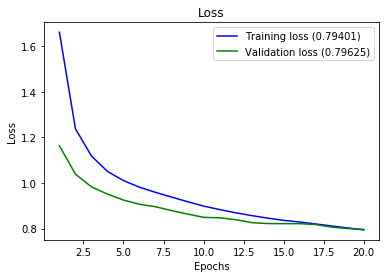

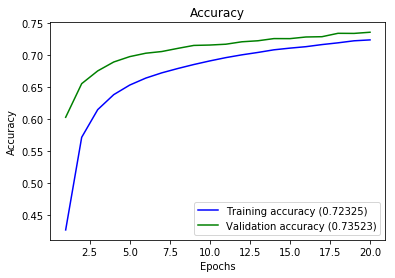

In [39]:
plot_history(history)

In [40]:
parallel_model.evaluate(
            x={'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test
            },
            y=y_test,
            batch_size=batch_size)


13200/13200 [==============================] - 4s 279us/step


[0.7962487683151708,
 0.7352272786877372,
 0.9164619162367414,
 0.6322033897233554]

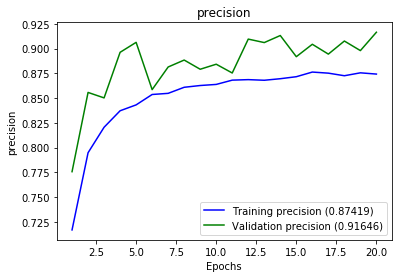

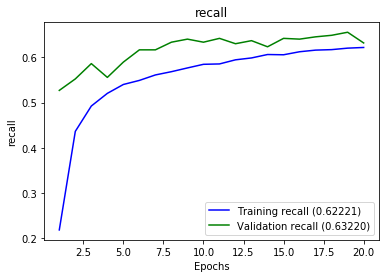

In [42]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('precision is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('precision')
    plt.xlabel('Epochs')
    plt.ylabel('precision')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training recall (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation recall (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('recall')
    plt.xlabel('Epochs')
    plt.ylabel('recall')
    plt.legend()
    plt.show()
    
    
plot_history(history)


In [43]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

<br>Train the neural network on  multichannel inputs namely deep layers of patent text segments 
 and deep layers of patent metadata.<br>

Fit the model/network

<br>Train the neural network on  multichannel inputs namely deep layers of Title and Technical Field.<br>

In [44]:


#contacting two input models
model_inputs_to_concat = [TI_deep,  TECHF_deep] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(64, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model3 =Model(inputs=[ TI_embedding_layer_input,
                      TECHF_embedding_layer_input
                      ],
              outputs=output, name='model')
model3.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       1897380     TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 30)       11125050    TECHF_embed_input[0][0]          
__________________________________________________________________________________________________
LSTM_TI (L

<br> Fit the model <br>

In [45]:
%%time
batch_size= 500 
num_epochs = 20


history3 = model3.fit(x={'TI_embed_input': TI_train,
             'TECHF_embed_input': TECHF_train
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test
            },
           y_test))

Train on 426800 samples, validate on 13200 samples
Epoch 1/20
426800/426800 [==============================] - 70s 163us/step - loss: 1.3541 - acc: 0.5704 - precision: 0.8138 - recall: 0.4359 - val_loss: 1.1573 - val_acc: 0.6293 - val_precision: 0.8175 - val_recall: 0.5542
Epoch 2/20
426800/426800 [==============================] - 63s 147us/step - loss: 1.2424 - acc: 0.5970 - precision: 0.8256 - recall: 0.4789 - val_loss: 1.1395 - val_acc: 0.6323 - val_precision: 0.8537 - val_recall: 0.5339
Epoch 3/20
426800/426800 [==============================] - 63s 148us/step - loss: 1.2134 - acc: 0.6057 - precision: 0.8298 - recall: 0.4933 - val_loss: 1.1267 - val_acc: 0.6369 - val_precision: 0.8571 - val_recall: 0.5390
Epoch 4/20
426800/426800 [==============================] - 63s 148us/step - loss: 1.1921 - acc: 0.6125 - precision: 0.8326 - recall: 0.4978 - val_loss: 1.1174 - val_acc: 0.6399 - val_precision: 0.8274 - val_recall: 0.5525
Epoch 5/20
426800/426800 [==============================]

In [46]:
model3.evaluate(
            x={'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test
            },
            y=y_test,
            batch_size=batch_size)

13200/13200 [==============================] - 1s 53us/step


[1.0471079814614672, 0.6565909155390479, 0.8305489258160982, 0.589830508374605]

<br>Train the neural network on  multichannel inputs namely deep layers of Title, abstrcat and Technical Field.<br>

In [47]:
import keras_metrics as km
#contacting two input models
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model4 = Model(inputs=[TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input
                     ],
              outputs=output, name='model')
model4.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       1897380     TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_

<br>Fit the model <br>

In [48]:
%%time
batch_size= 500 
num_epochs = 20


history4 = model4.fit(x={'TI_embed_input': TI_train,
                         'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test
            },
           y_test))

Train on 426800 samples, validate on 13200 samples
Epoch 1/20
426800/426800 [==============================] - 195s 456us/step - loss: 1.0468 - acc: 0.6492 - precision: 0.8495 - recall: 0.5545 - val_loss: 0.9798 - val_acc: 0.6725 - val_precision: 0.8531 - val_recall: 0.6102
Epoch 2/20
426800/426800 [==============================] - 186s 436us/step - loss: 0.9669 - acc: 0.6683 - precision: 0.8559 - recall: 0.5778 - val_loss: 0.9508 - val_acc: 0.6798 - val_precision: 0.8831 - val_recall: 0.6017
Epoch 3/20
426800/426800 [==============================] - 186s 436us/step - loss: 0.9360 - acc: 0.6781 - precision: 0.8581 - recall: 0.5896 - val_loss: 0.9264 - val_acc: 0.6901 - val_precision: 0.8892 - val_recall: 0.6119
Epoch 4/20
426800/426800 [==============================] - 188s 440us/step - loss: 0.9096 - acc: 0.6872 - precision: 0.8636 - recall: 0.5993 - val_loss: 0.8990 - val_acc: 0.6987 - val_precision: 0.8776 - val_recall: 0.6322
Epoch 5/20
426800/426800 [===========================

In [49]:
model4.evaluate(
            x={'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test
            },
            y=y_test,
            batch_size=batch_size)


13200/13200 [==============================] - 2s 153us/step


[0.8073388044581269, 0.730227273070451, 0.8883720928166576, 0.6474576270089055]

<br>Train the neural network on  multichannel inputs namely deep layers of Title, Technical Field, Inventors, and Assignees.<br>

In [50]:
import keras_metrics as km

#contacting two input models
model_inputs_to_concat = [TI_deep, TECHF_deep,  pas, invs] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model5 =Model(inputs=[ TI_embedding_layer_input,
                      TECHF_embedding_layer_input,
                     pa_input,
                      inv_input],
              outputs=output, name='model')
model5.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       1897380     TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 30)       11125050    TECHF_embed_input[0][0]          
__________________________________________________________________________________________________
LSTM_TI (L

<br> Fit the mode. <br>

In [51]:
%%time
batch_size= 500 
num_epochs = 20


history5 = model5.fit(x={'TI_embed_input': TI_train,
             'TECHF_embed_input': TECHF_train,
             'pa_input': train_pa_one_hot,
             'inv_input': train_inv_one_hot
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
           y_test))

Train on 426800 samples, validate on 13200 samples
Epoch 1/20
426800/426800 [==============================] - 102s 240us/step - loss: 1.0721 - acc: 0.6535 - precision: 0.8499 - recall: 0.5604 - val_loss: 1.0215 - val_acc: 0.6737 - val_precision: 0.8522 - val_recall: 0.5864
Epoch 2/20
426800/426800 [==============================] - 89s 208us/step - loss: 0.9803 - acc: 0.6757 - precision: 0.8572 - recall: 0.5942 - val_loss: 1.0081 - val_acc: 0.6719 - val_precision: 0.8369 - val_recall: 0.6000
Epoch 3/20
426800/426800 [==============================] - 88s 207us/step - loss: 0.9617 - acc: 0.6797 - precision: 0.8588 - recall: 0.6018 - val_loss: 1.0086 - val_acc: 0.6750 - val_precision: 0.8506 - val_recall: 0.5983
Epoch 4/20
426800/426800 [==============================] - 87s 204us/step - loss: 0.9511 - acc: 0.6826 - precision: 0.8566 - recall: 0.5991 - val_loss: 1.0068 - val_acc: 0.6739 - val_precision: 0.8361 - val_recall: 0.5966
Epoch 5/20
426800/426800 [==============================

In [52]:
model5.evaluate(
            x={'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
            y=y_test,
            batch_size=batch_size)


13200/13200 [==============================] - 1s 95us/step


[0.9944516041062095, 0.6806818156531362, 0.852731591246382, 0.6084745761680552]

In [53]:
model5.metrics_names

['loss', 'acc', 'precision', 'recall']

In [54]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('precision is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('precision')
    plt.xlabel('Epochs')
    plt.ylabel('precision')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training recall (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation recall (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('recall')
    plt.xlabel('Epochs')
    plt.ylabel('recall')
    plt.legend()
    plt.show()


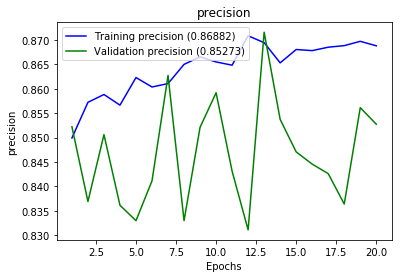

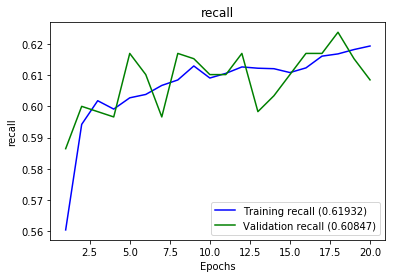

In [55]:
plot_history(history5)

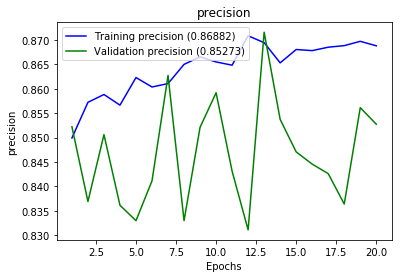

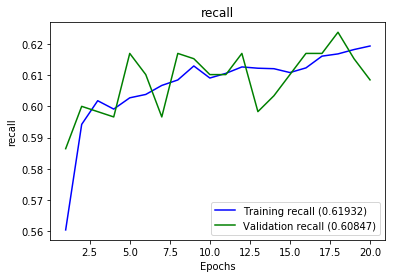

In [56]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'precision' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'recall' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('precision is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation precision (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('precision')
    plt.xlabel('Epochs')
    plt.ylabel('precision')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training recall (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation recall (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('recall')
    plt.xlabel('Epochs')
    plt.ylabel('recall')
    plt.legend()
    plt.show()
    
    
plot_history(history5)
